# Random Forest

**Rossmann Store Sales**
Forecast sales using store, promotion, and competitor data

This is a Kaggle competition and can be found [here](https://www.kaggle.com/competitions/rossmann-store-sales/overview)

In this notebook I use a `Random Forest` to predict `Sales`.

The validation RMSE is `1379`
On the full train set, Root Mean Square Percentage Error is `0.29`

In [50]:
from pathlib import Path
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.pipeline import Pipeline
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import RandomizedSearchCV, GridSearchCV
from scipy.stats import randint as sp_randint     

# my functions
from utils import RMSPE, print_best_model_metrics
from pipeline import full_pipeline

# Load data

In [51]:
# Load the dataset
def load_ds(path: Path, filename: str) -> pd.DataFrame:
    """Read the dataset csv file as a pandas dataframe."""
    return pd.read_csv(path / filename)

# Load dataset
dataset_path = Path().absolute() / "data"
filename = "X_y_train.csv"
X_y_train = load_ds(dataset_path, filename)

print(f"Shape: {X_y_train.shape}")

Shape: (675470, 18)


In [52]:
X_y_train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 675470 entries, 0 to 675469
Data columns (total 18 columns):
 #   Column                     Non-Null Count   Dtype  
---  ------                     --------------   -----  
 0   Store                      675470 non-null  int64  
 1   DayOfWeek                  675470 non-null  int64  
 2   Date                       675470 non-null  object 
 3   Sales                      675470 non-null  int64  
 4   Customers                  675470 non-null  int64  
 5   Open                       675470 non-null  int64  
 6   Promo                      675470 non-null  int64  
 7   StateHoliday               675470 non-null  object 
 8   SchoolHoliday              675470 non-null  int64  
 9   StoreType                  675470 non-null  object 
 10  Assortment                 675470 non-null  object 
 11  CompetitionDistance        673738 non-null  float64
 12  CompetitionOpenSinceMonth  460686 non-null  float64
 13  CompetitionOpenSinceYear   46

In [53]:
X_train = X_y_train # include "Sales", CombinedAttributesAdder() drops it
y_train = X_y_train.loc[:, "Sales"].copy()

# Random forest

In [54]:
rf = Pipeline([
    # Pre-processing pipeline
    ("preparation", full_pipeline),
    # Random forest
    ("rf", RandomForestRegressor(n_estimators=100, max_depth=10, random_state=123))])

In [55]:
rf.fit(X_train, y_train)

Pipeline(steps=[('preparation',
                 Pipeline(steps=[('attribs_adder', CombinedAttributesAdder()),
                                 ('cols_transformer',
                                  ColumnTransformer(transformers=[('num',
                                                                   Pipeline(steps=[('imputer',
                                                                                    SimpleImputer()),
                                                                                   ('std_scaler',
                                                                                    StandardScaler())]),
                                                                   ['SchoolHoliday',
                                                                    'Promo2',
                                                                    'Month_mean',
                                                                    'Store_mean',
                                                                    'DayOfWeek_mean',
                                                                    'PromoStore_mean',
                                                                    'CD_clip_bins_clip']),
                                                                  ('cat',
                                                                   Pipeline(steps=[('imputer',
                                                                                    SimpleImputer(strategy='most_frequent')),
                                                                                   ('one_hot',
                                                                                    OneHotEncoder(drop='if_binary'))]),
                                                                   ['StoreType',
                                                                    'Assortment'])]))])),
                ('rf', RandomForestRegressor(max_depth=10, random_state=123))])

In [56]:
rf.score(X_train, y_train)

0.8588495257069346

In [57]:
y_pred = rf.predict(X_train)

In [58]:
mean_squared_error(y_train, y_pred, squared=False)

1166.3421376798294

In [59]:
np.sqrt(np.sum((y_train -y_pred)**2) / len(y_train))

1166.3421376798294

In [60]:
RMSPE(y_train, y_pred)

0.255537951741148

The Root Mean Square Percentage Error on the train set is:

`RMSPE = 0.26`

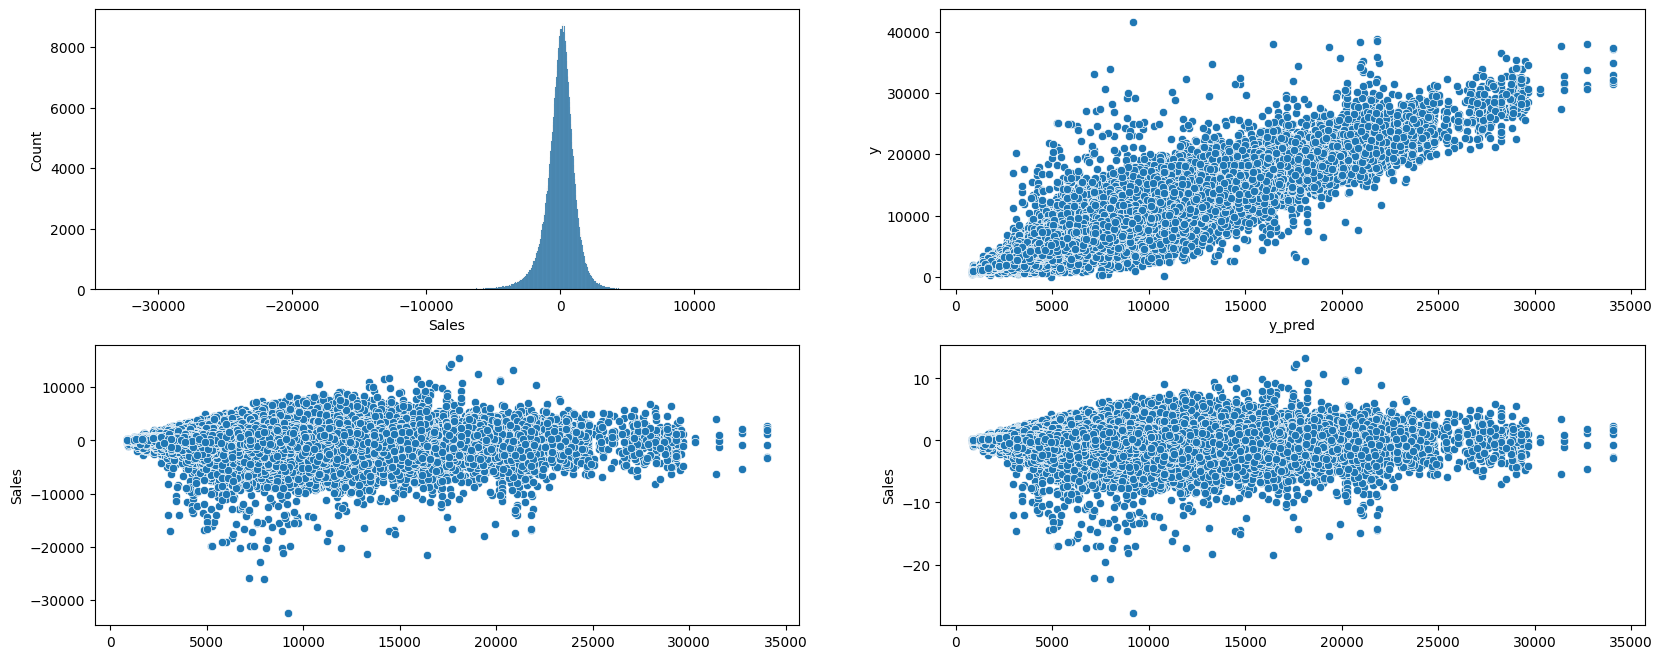

In [61]:
res = (y_pred - y_train)
res_normed = (res - np.mean(res))/np.std(res)


plt.figure(figsize=(20, 8))

plt.subplot(2, 2, 1)
sns.histplot(x=res)

plt.subplot(2, 2, 2)
# sns.histplot(x=res_2)
sns.scatterplot(x=y_pred, y=y_train)
plt.xlabel("y_pred")
plt.ylabel("y")

plt.subplot(2, 2, 3)
sns.scatterplot(x=y_pred, y=res)

plt.subplot(2, 2, 4)
sns.scatterplot(x=y_pred, y=res_normed)

plt.show()

# Randomized Search CV

In [62]:
a1 = sp_randint(2, 11)
a1.rvs(2)

array([4, 8])

In [64]:
rf = Pipeline([
    # Pre-processing pipeline
    ("preparation", full_pipeline),
    # Random forest
    ("rf", RandomForestRegressor(random_state=123))
])

param_dist ={
    "rf__n_estimators": sp_randint(100, 200),
    "rf__max_depth": range(2, 6), # [3, 5, 10],
    "rf__min_samples_split": sp_randint(2, 11) # [2, 5, 10]
}

rf_hgscv_1 = RandomizedSearchCV(
    estimator=rf,
    param_distributions=param_dist,
    cv=5,
    scoring='neg_mean_squared_error',
    verbose=2, #1,
    n_iter=20,
    )

The fit takes about 50 minutes

In [65]:
rf_hgscv_1.fit(X_train, y_train)

Fitting 5 folds for each of 20 candidates, totalling 100 fits
[CV] END rf__max_depth=3, rf__min_samples_split=4, rf__n_estimators=145; total time=  29.7s
[CV] END rf__max_depth=3, rf__min_samples_split=4, rf__n_estimators=145; total time=  27.9s
[CV] END rf__max_depth=3, rf__min_samples_split=4, rf__n_estimators=145; total time=  29.2s
[CV] END rf__max_depth=3, rf__min_samples_split=4, rf__n_estimators=145; total time=  28.8s
[CV] END rf__max_depth=3, rf__min_samples_split=4, rf__n_estimators=145; total time=  27.8s
[CV] END rf__max_depth=5, rf__min_samples_split=5, rf__n_estimators=112; total time=  31.6s
[CV] END rf__max_depth=5, rf__min_samples_split=5, rf__n_estimators=112; total time=  32.0s
[CV] END rf__max_depth=5, rf__min_samples_split=5, rf__n_estimators=112; total time=  31.9s
[CV] END rf__max_depth=5, rf__min_samples_split=5, rf__n_estimators=112; total time=  31.6s
[CV] END rf__max_depth=5, rf__min_samples_split=5, rf__n_estimators=112; total time=  32.0s
[CV] END rf__max_d

RandomizedSearchCV(cv=5,
                   estimator=Pipeline(steps=[('preparation',
                                              Pipeline(steps=[('attribs_adder',
                                                               CombinedAttributesAdder()),
                                                              ('cols_transformer',
                                                               ColumnTransformer(transformers=[('num',
                                                                                                Pipeline(steps=[('imputer',
                                                                                                                 SimpleImputer()),
                                                                                                                ('std_scaler',
                                                                                                                 StandardScaler())]),
                                                                                                ['SchoolHoliday',
                                                                                                 'Promo2',
                                                                                                 'Month_mean',
                                                                                                 'Store_mean',
                                                                                                 'DayOfWeek_mean',
                                                                                                 'PromoStore_mean',
                                                                                                 '...
                                                                                                 'Assortment'])]))])),
                                             ('rf',
                                              RandomForestRegressor(random_state=123))]),
                   n_iter=20,
                   param_distributions={'rf__max_depth': range(2, 6),
                                        'rf__min_samples_split': <scipy.stats._distn_infrastructure.rv_discrete_frozen object at 0x7f9df3903d90>,
                                        'rf__n_estimators': <scipy.stats._distn_infrastructure.rv_discrete_frozen object at 0x7f9df38afee0>},
                   scoring='neg_mean_squared_error', verbose=2)

In [68]:
print_best_model_metrics(rf_hgscv_1, X_train, y_train)

Best parameters:
{'rf__max_depth': 5, 'rf__min_samples_split': 2, 'rf__n_estimators': 187}

Best score:
neg_mean_squared_error: -1912783.392
RMSE: 1383.034

Considering the full train set:
neg_mean_squared_error: -1902815.478
RMSE: 1379.426
Root Mean Square Percentage Error: 0.29


Best parameters:
- max_depth: `5`
- min_samples_leaf: `2`
- n_estimators: `187`

Score best model:


Mean cross validation scores:
- RMSE: `1383`

Considering the full train set:
- RMSE: `1379`
- Root Mean Square Percentage Error: `0.29`